In [1]:
from MovieBookAnalysis import *
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from copy import deepcopy

/Users/kenn/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
IMDB_ratings = pd.read_csv('05_15_movie_books_IMDB_ratings.csv', index_col=0)

In [3]:
GR_ratings = pd.read_csv('05_15_movie_books_GR_ratings.csv', index_col=0)

In [4]:
MC_ratings = pd.read_csv('05_15_movie_books_MC_ratings.csv', index_col=0)

In [5]:
dummies = pd.get_dummies(IMDB_ratings.MPAArating)
IMDB_ratings = pd.concat([IMDB_ratings, dummies], axis=1)
IMDB_ratings = IMDB_ratings.rename(columns = {'PG-13':'PG13'})

In [6]:
all_df = IMDB_ratings.merge(GR_ratings, on='Title').merge(MC_ratings, on='Title')

In [7]:
all_df.head()

,Title,Budget,Gross,MPAArating,Runtime,IMDBRating,IMDBRatingCount,IMDBMCRating,IMDBMCRatingCount,APPROVED,...,R,TV-14,UNRATED,X,GRRating,GRRatingCount,MCUserRating,MCUserRatingCount,MCCriticRating,MCCriticRatingCount
0,The Wolf of Wall Street,100000000,116866727,R,180,8.2,705753,NaN,NaN,0,...,1,0,0,0,3.64,18175,7.1,1572,75,47
1,Into the Wild,15000000,18352454,R,148,8.2,401238,NaN,NaN,0,...,1,0,0,0,3.92,539534,8.2,348,73,38
2,Gone Girl,61000000,167735396,R,149,8.1,517073,NaN,NaN,0,...,1,0,0,0,3.99,1240870,8.1,1138,79,49
3,Going Clear: Scientology and the Prison of Belief,NaN,NaN,NOT RATED,119,8.1,19936,NaN,NaN,0,...,0,0,0,0,3.99,24468,8.4,49,80,11
4,The Pact,NaN,NaN,NaN,84,8.1,31,NaN,NaN,0,...,0,0,0,0,3.99,211335,6.7,23,54,10


In [8]:
all_df['logGRRating'] = np.log(all_df.GRRating)
all_df['squareIMDBRatingCount'] = np.square(all_df.IMDBRatingCount)

In [9]:
all_df.head()

,Title,Budget,Gross,MPAArating,Runtime,IMDBRating,IMDBRatingCount,IMDBMCRating,IMDBMCRatingCount,APPROVED,...,UNRATED,X,GRRating,GRRatingCount,MCUserRating,MCUserRatingCount,MCCriticRating,MCCriticRatingCount,logGRRating,squareIMDBRatingCount
0,The Wolf of Wall Street,100000000,116866727,R,180,8.2,705753,NaN,NaN,0,...,0,0,3.64,18175,7.1,1572,75,47,1.291984,4.980873e+11
1,Into the Wild,15000000,18352454,R,148,8.2,401238,NaN,NaN,0,...,0,0,3.92,539534,8.2,348,73,38,1.366092,1.609919e+11
2,Gone Girl,61000000,167735396,R,149,8.1,517073,NaN,NaN,0,...,0,0,3.99,1240870,8.1,1138,79,49,1.383791,2.673645e+11
3,Going Clear: Scientology and the Prison of Belief,NaN,NaN,NOT RATED,119,8.1,19936,NaN,NaN,0,...,0,0,3.99,24468,8.4,49,80,11,1.383791,3.974441e+08
4,The Pact,NaN,NaN,NaN,84,8.1,31,NaN,NaN,0,...,0,0,3.99,211335,6.7,23,54,10,1.383791,9.610000e+02


In [10]:
def avgMSEForLinReg(df, IV, DVs, k=10):
    MSE_list = []
    
    var_list = DVs
    var_list.insert(0, IV)
    tempDF = df[var_list].dropna()
    
    for x in range(k):
        y_train, y_test, X_train, X_test = train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2)

        model = LinearRegression(normalize=True)
        model.fit(X_train, y_train)

        MSE = np.mean((model.predict(X_test)-y_test)**2)
        MSE_list.append(MSE)
        
    return np.mean(MSE_list)

In [11]:
def CrossValidateForMSEAtDiffLambda(df, IV, DVs):
    
    avgMSELasso_values = []
    avgMSERidge_values = []
    avgMSELinReg_values = []
    avgR2Lasso_values = []
    avgR2Ridge_values = []
    avgR2LinReg_values = []
    
    
    lmda_values = [x*0.00005 for x in range(1, 1001)]
    #lmda_values = [x*0.00005 for x in range(1, 11)]
    
    var_list = deepcopy(DVs)
    var_list.insert(0, IV)
    tempDF = df[var_list].dropna()
    
    for lmda in lmda_values:
        MSELasso_list = []
        MSERidge_list = []
        MSELinReg_list = []
        R2Lasso_list = []
        R2Ridge_list = []
        R2LinReg_list = []
        
        for x in range(10):
            y_train, y_test, X_train, X_test  = train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2)
            
            #print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)
            #print(train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2))
            
            model = Lasso(alpha=lmda, normalize=True)
            model2 = Ridge(alpha=lmda, normalize=True)
            model3 = LinearRegression(normalize=True)
            model.fit(X_train, y_train)
            model2.fit(X_train, y_train)
            model3.fit(X_train, y_train)
            #print(model.score(X_test, y_test), model2.score(X_test, y_test))
            MSELasso = np.mean((model.predict(X_test)-y_test)**2)
            MSELasso_list.append(MSELasso)
            MSERidge = np.mean((model2.predict(X_test)-y_test)**2)
            MSERidge_list.append(MSERidge)
            MSELinReg = np.mean((model3.predict(X_test)-y_test)**2)
            MSELinReg_list.append(MSELinReg)
            R2Lasso_list.append(model.score(X_test, y_test))
            R2Ridge_list.append(model2.score(X_test, y_test))
            R2LinReg_list.append(model3.score(X_test, y_test))
            #print(X_test, y_test)
            
            
        avgMSELasso_values.append(np.mean(MSELasso_list))
        avgMSERidge_values.append(np.mean(MSERidge_list))
        avgMSELinReg_values.append(np.mean(MSELinReg_list))
        avgR2Lasso_values.append(np.mean(R2Lasso_list))
        avgR2Ridge_values.append(np.mean(R2Ridge_list))
        avgR2LinReg_values.append(np.mean(R2LinReg_list))
        
    minMSE1 = min(avgMSELasso_values)
    idx = avgMSELasso_values.index(minMSE1)
    minLmda = lmda_values[idx]
    LassoAvgR2 = avgR2Lasso_values[idx]
    
    minMSE2 = min(avgMSERidge_values)
    idx2 = avgMSERidge_values.index(minMSE2)
    minLmda2 = lmda_values[idx2]
    RidgeAvgR2 = avgR2Ridge_values[idx2]
    
    LinRegAvgR2 = np.mean(avgR2LinReg_values)

    y_train, y_test, X_train, X_test = train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2)
    model1 = Lasso(alpha=minLmda, normalize=True)
    model1.fit(X_train, y_train)
    model2 = Ridge(alpha=minLmda2, normalize=True)
    model2.fit(X_train, y_train)
    model3 = LinearRegression(normalize=True)
    model3.fit(X_train, y_train)

        
        
    
    print(minLmda, minMSE1, model1.coef_, model1.intercept_, np.mean(avgR2Lasso_values))
    print(minLmda2, minMSE2, model2.coef_, model2.intercept_, np.mean(avgR2Ridge_values))
    print(model3.coef_, model3.intercept_, np.mean(avgR2LinReg_values))
        
    return lmda_values, avgMSELasso_values, avgMSERidge_values, avgMSELinReg_values, avgR2Lasso_values, avgR2Ridge_values, avgR2LinReg_values 

In [12]:
def plotMSEandR2vLambda(df, IV, DVs):
    lmda_values, avgMSELasso_values, avgMSERidge_values, avgMSELinReg_values, avgR2Lasso_values, avgR2Ridge_values, avgR2LinReg_values  = CrossValidateForMSEAtDiffLambda(df, IV, DVs)
    
    fig, axarr = plt.subplots(6, sharex=True)
    fig.set_size_inches(10, 7, forward=True)
    
    axarr[0].plot(lmda_values, avgMSELasso_values)
    axarr[0].set_title('Average MSE for k = 10 at different Lambda Values (Lasso)')
    #axarr[0].set_xlabel('Lambda')
    axarr[0].set_ylabel('Avg Test MSE')
    
    axarr[1].plot(lmda_values, avgMSERidge_values)
    axarr[1].set_title('Average MSE for k = 10 at different Lambda Values (Ridge)')
    #axarr[1].set_xlabel('Lambda')
    axarr[1].set_ylabel('Avg Test MSE')
    
    axarr[2].plot(lmda_values, avgMSELinReg_values)
    axarr[2].set_title('Average MSE for k = 10 at different Lambda Values (LinReg)')
    #axarr[2].set_xlabel('Lambda')
    axarr[2].set_ylabel('Avg Test MSE')
    
    axarr[3].plot(lmda_values, avgR2Lasso_values)
    axarr[3].set_title('Average R2 for k = 10 at different Lambda Values (Lasso)')
    #axarr[3].set_xlabel('Lambda')
    axarr[3].set_ylabel('Avg Test R2')
    
    axarr[4].plot(lmda_values, avgR2Ridge_values)
    axarr[4].set_title('Average R2 for k = 10 at different Lambda Values (Ridge)')
    #axarr[4].set_xlabel('Lambda')
    axarr[4].set_ylabel('Avg Test R2')
    
    axarr[5].plot(lmda_values, avgR2LinReg_values)
    axarr[5].set_title('Average R2 for k = 10 at different Lambda Values (LinReg)')
    axarr[5].set_xlabel('Lambda')
    axarr[5].set_ylabel('Avg Test R2')
    

0.0046 0.0148948476472 [  3.07053012e-13   0.00000000e+00   3.91827452e-07  -0.00000000e+00
   0.00000000e+00   0.00000000e+00] 7.5652760482 0.000697167269476
0.0046 0.0122717900679 [  4.30353424e-13  -7.26121427e-03   7.04608158e-07  -1.28659253e-09
  -1.20031321e-10   1.52698044e-03] 7.3646362857 0.344947485065
[  3.98504624e-13  -7.27470714e-03   7.27593095e-07  -1.29940642e-09
  -1.25581132e-10   1.52433008e-03] 7.36303250164 0.330940574081


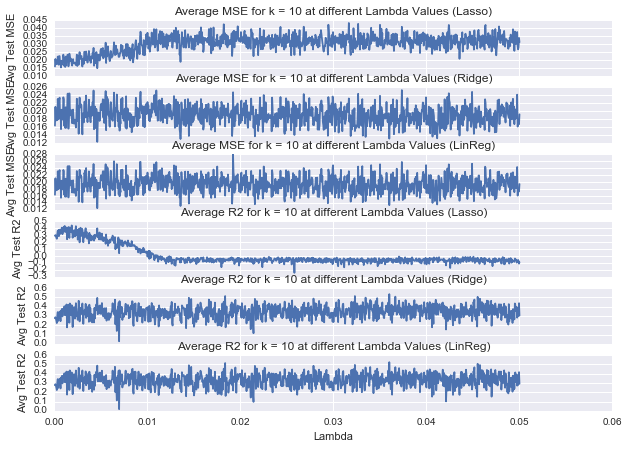

In [14]:
plotMSEandR2vLambda(all_df, 'IMDBRating', ['squareIMDBRatingCount', 'R', 'IMDBRatingCount', 'Budget', 'Gross', 'Runtime'])

In [ ]:
plotMSEvLambda(all_df, 'IMDBRating', ['logGRRating', 'R', 'IMDBRatingCount'])

In [ ]:
plotMSEvLambda(all_df, 'IMDBRating', ['IMDBRatingCount', 'squareIMDBRatingCount'])

In [ ]:
avgMSEForLinReg(all_df, 'IMDBRating', ['IMDBRatingCount', 'squareIMDBRatingCount'], 10)